In [1]:
%matplotlib inline

import os, pathlib
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")
import seaborn as sns

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import PCA

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import simTools as st
        from tools import ccaTools as cca
        import params
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs
        rnn_defs = params.rnn_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

    finally:
        os.chdir(NBPath)

    print('Done')

FIGPATH = params.figPath / 'fig5'
if not os.path.exists(FIGPATH):
    os.makedirs(FIGPATH)

Done


In [2]:
rnn_defs.RESULTS_FOLDER = 'results'
seeds1 = rnn_defs.SEEDS1
seeds2 = rnn_defs.SEEDS2
seeds1 = range(1230,1240)
seeds2 = range(4560,4570)
sim1=1
sims2 = [1,2,3,4]#[6,2,3,1] #alpha = 0.0, .05, .25, .5, 1.0, 2.0 
alphas = [0.0, 0.05, 0.25, 0.5]

### Fig 5B: RNN output

In [3]:
@utility.report
def plot_rnn_position(ax, seed, sim_number):
    st.graph_sim_position(seed, sim_number, ax = ax)

Executed: `plot_rnn_position` in 1.3s
Executed: `plot_rnn_position` in 0.3s
Executed: `plot_rnn_position` in 0.3s
Executed: `plot_rnn_position` in 0.3s
Executed: `plot_rnn_position` in 0.3s


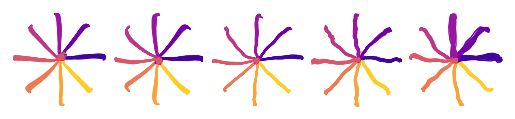

In [4]:
fig=plt.figure(dpi=100)
gs = fig.add_gridspec(wspace=0, nrows = 1, ncols = len(sims2)+1)
ax = fig.add_subplot(gs[0])    
plot_rnn_position(ax, seed=seeds1[rnn_defs.seed_idx_ex], sim_number = sim1)

for i, sim2 in enumerate(sims2):
    ax = fig.add_subplot(gs[1+i])
    plot_rnn_position(ax, seed=seeds2[rnn_defs.seed_idx_ex], sim_number = sim2)

fig.savefig(FIGPATH / 'RNN-output.pdf', format='pdf', bbox_inches='tight')


### Fig 5C: RNN MSE

In [5]:
import matplotlib.transforms as transforms

@utility.report

def plot_mse(ax, seeds1, seeds2, sim1, sim2_list, alphas):

    mse1 = st.get_mse(seeds1,sim1)
    mse_df1 = pd.DataFrame(data = {'mse': mse1, 'group': 'Standard'})
    mse_df = mse_df1
    for sim2, alpha in zip(sim2_list, alphas):
        mse2 = st.get_mse(seeds2, sim2)
        mse_df2 = pd.DataFrame(data = {'mse': mse2, 'group': f'Penalised, alpha={alpha}'})

        mse_df = pd.concat([mse_df, mse_df2])

    colors = utility.get_colors(len(alphas), 'spring')
    colors = [params.colors.Sim1CC] + (colors)
    # sns.set_palette(sns.color_palette(colors))
    sns.pointplot(data = mse_df, x = 'group', y = 'mse', ax = ax, palette = colors,scale = 0.7, ci = 'sd')
    sns.stripplot(data = mse_df, x = 'group', y = 'mse', ax = ax, palette = colors, alpha = 0.5)

    ax.set_xlabel('Networks')
    ax.set_ylabel('MSE')
    ax.xaxis.set_tick_params(rotation = 90)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


Executed: `plot_mse` in 11.4s


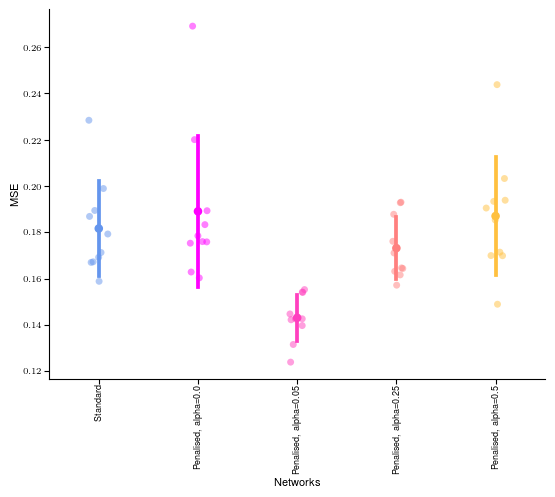

In [6]:
fig=plt.figure(dpi=100)
gs = fig.add_gridspec(wspace=0)
ax = fig.add_subplot(gs[0])

plot_mse(ax, seeds1, seeds2, sim1, sims2, alphas)
fig.savefig(FIGPATH / 'RNN-mses.pdf', format='pdf', bbox_inches='tight')


### Fig 5E: Behavioral correlation

In [7]:
def get_full_rnn_data(seeds, sim_number):
    dfs = []
    for seed in seeds:
        dfs.append(st.get_processed_pyaldata(seed, sim_number))

    return dfs

In [8]:
@utility.report
def plot_rnn_behav_corr(ax, allDFs_MCx1,allDFs_MCx2_list, alphas):
    
    # across standard or constrained networks
    across_corrs_rnns1 = st.trim_across_rnn_corr(allDFs_MCx1)
    CC_corr_rnn_across1=[]
    for i in range(len(allDFs_MCx1)):
        for j in range(len(allDFs_MCx1)):
            if j<=i: continue
            CC_corr_rnn_across1.append(np.mean(across_corrs_rnns1[allDFs_MCx1[i].seed[0]][allDFs_MCx1[j].seed[0]]))
    df_across1 = pd.DataFrame(data = {'corr': CC_corr_rnn_across1, 'group': 'Across \n standard'})
    corr_df = df_across1

    for alpha, allDFs_MCx2 in zip(alphas,allDFs_MCx2_list):
        across_corrs_rnns2 = st.trim_across_rnn_corr(allDFs_MCx2)
        CC_corr_rnn_across2=[]
        for i in range(len(allDFs_MCx2)):
            for j in range(len(allDFs_MCx2)):
                if j<=i: continue
                CC_corr_rnn_across2.append(np.mean(across_corrs_rnns2[allDFs_MCx2[i].seed[0]][allDFs_MCx2[j].seed[0]]))
                df_across2 = pd.DataFrame(data = {'corr': CC_corr_rnn_across2, 'group': f'Across \n constrained, alpha={alpha}'})
        corr_df = pd.concat([corr_df, df_across2])
    # df_across = pd.DataFrame(data = {'corr': CC_corr_rnn, 'group': 'Across'})
    #     corr_df = pd.concat([df_across, df_across1, df_across2])

    colors = utility.get_colors(len(alphas), 'spring')
    colors = [params.colors.Sim1CC] + (colors)
    sns.set_palette(sns.color_palette(colors))
    sns.pointplot(data = corr_df, x = 'group', y = 'corr', ax = ax, palette = colors, scale = 0.7, ci='sd') 
    sns.stripplot(data = corr_df, x = 'group', y = 'corr', ax = ax, palette = colors, alpha = 0.3)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Behavioural correlation')
    ax.set_xlabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([.75,1.03])
    ax.xaxis.set_tick_params(rotation = 45)
    

Executed: `plot_rnn_behav_corr` in 873.8s


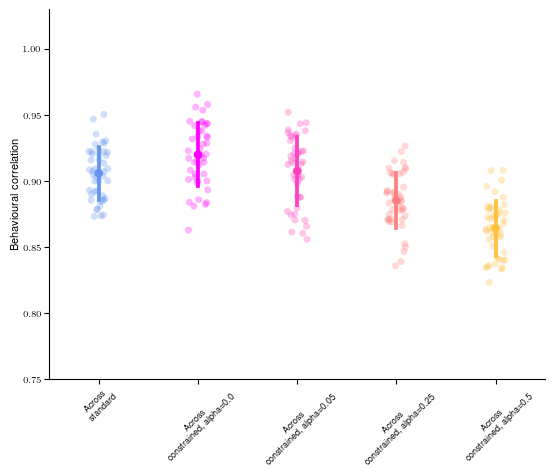

In [9]:
allDFs_rnn1 = get_full_rnn_data(seeds1, sim_number = sim1)
allDFs_rnn2_list = []
for sim2 in sims2:
    allDFs_rnn2 = get_full_rnn_data(seeds2, sim_number = sim2)
    allDFs_rnn2_list.append(allDFs_rnn2)
    
fig=plt.figure(dpi=100)
ax = fig.add_subplot()           

plot_rnn_behav_corr(ax, allDFs_rnn1,allDFs_rnn2_list, alphas)
fig.savefig(FIGPATH / 'RNN-behav_corr.pdf', format='pdf', bbox_inches='tight')


### Fig 5E: RNN CCA

In [10]:
@utility.report
def plot_rnn_cca(ax, ax_hist, allDFs_rnn1, allDFs_rnn2_list, alphas):

    rnn_epoch = rnn_defs.exec_epoch

    #CCs across networks in standard or constrained networks
    across_ccs1 = st.get_cc_across(allDFs_rnn1, rnn_defs.n_components, epoch_fun = rnn_epoch)

    # plotting
    x_ = np.arange(1,rnn_defs.n_components+1)
    utility.shaded_errorbar(ax, x_, across_ccs1, color=params.colors.Sim1CC, marker = '<', ls='--')

    ax.set_ylim([-.05,1.05])
    ax.set_xlim([.6,rnn_defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Canonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,monkey_defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    
    ax.annotate("", xy=(5, 0.58), xytext=(5, 0.95), color = 'grey', arrowprops=dict(arrowstyle="->")) 
    ax.annotate("penalisation", xy=(5.25, 0.75), fontsize = 7)   
    
    #plot the hist
    bins = np.arange(0,1.05,0.05)
    ax_hist.xaxis.set_visible(False)
    ax_hist.set_facecolor('None')
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['left'].set_bounds([0,1])
    ax_hist.set_ylim([-.05,1])

    ax_hist.hist(across_ccs1[:4,:].mean(axis=0), bins=bins, density=True, label=f'Standard\n($n={across_ccs1.shape[1]}$)',
            color=params.colors.Sim1CC, alpha=.8, orientation='horizontal')

    colors = utility.get_colors(len(alphas), 'spring')
    for i, allDFs_rnn2 in enumerate(allDFs_rnn2_list):
        alpha = alphas[i]

        across_ccs2 = st.get_cc_across(allDFs_rnn2, rnn_defs.n_components, epoch_fun = rnn_epoch)

        utility.shaded_errorbar(ax, x_, across_ccs2, color=colors[i], marker = '<', ls='--')

        ax_hist.hist(across_ccs2[:4,:].mean(axis=0), bins=bins, density=True, label=f'Penalised\n($n={across_ccs2.shape[1]}$), alpha = {alpha}',
            color=colors[i], alpha=.8, orientation='horizontal')
    
    ax_hist.tick_params('y', direction='out')
    ax_hist.set_yticklabels([])
    ax_hist.legend(loc=(0,-.05),title="Across networks")

Executed: `plot_rnn_cca` in 49.5s


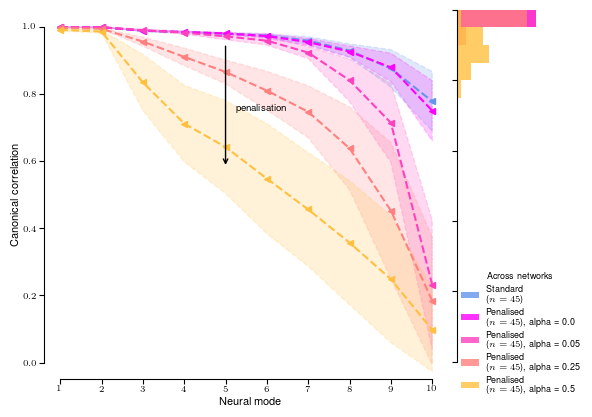

In [11]:
allDFs_rnn2_list = []
for i, sim2 in enumerate(sims2):
    allDFs_rnn2_list.append(get_full_rnn_data(seeds2, sim_number = sim2))

fig=plt.figure(dpi=100)
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

ax = fig.add_subplot(gs[0])
ax_ = fig.add_subplot(gs[1])

plot_rnn_cca(ax, ax_, allDFs_rnn1, allDFs_rnn2_list, alphas)

plt.savefig(FIGPATH / 'RNN-CCA.pdf', format= 'pdf')
plt.show()

### Fig 5F&G: Dimensionality and variance of weight changes

In [12]:
rows = []

for i, sim in enumerate(sims2):
    for seed in seeds2:    
        dw = st.get_weight_changes(seed,sim)['rec']

        #dimensionality
        pca = PCA().fit(dw)
        ex_var = pca.explained_variance_
        dimensionality = np.sum(ex_var) ** 2 / np.sum(ex_var ** 2)
        #standard dev
        var = np.var(dw.flatten())

        dic = {
            'sim': sim,
            'seed': seed,
            'dimensionality': dimensionality,    
            'var': var,
            'alpha': alphas[i],
        }

        rows.append(dic)

data = pd.DataFrame(data = rows)

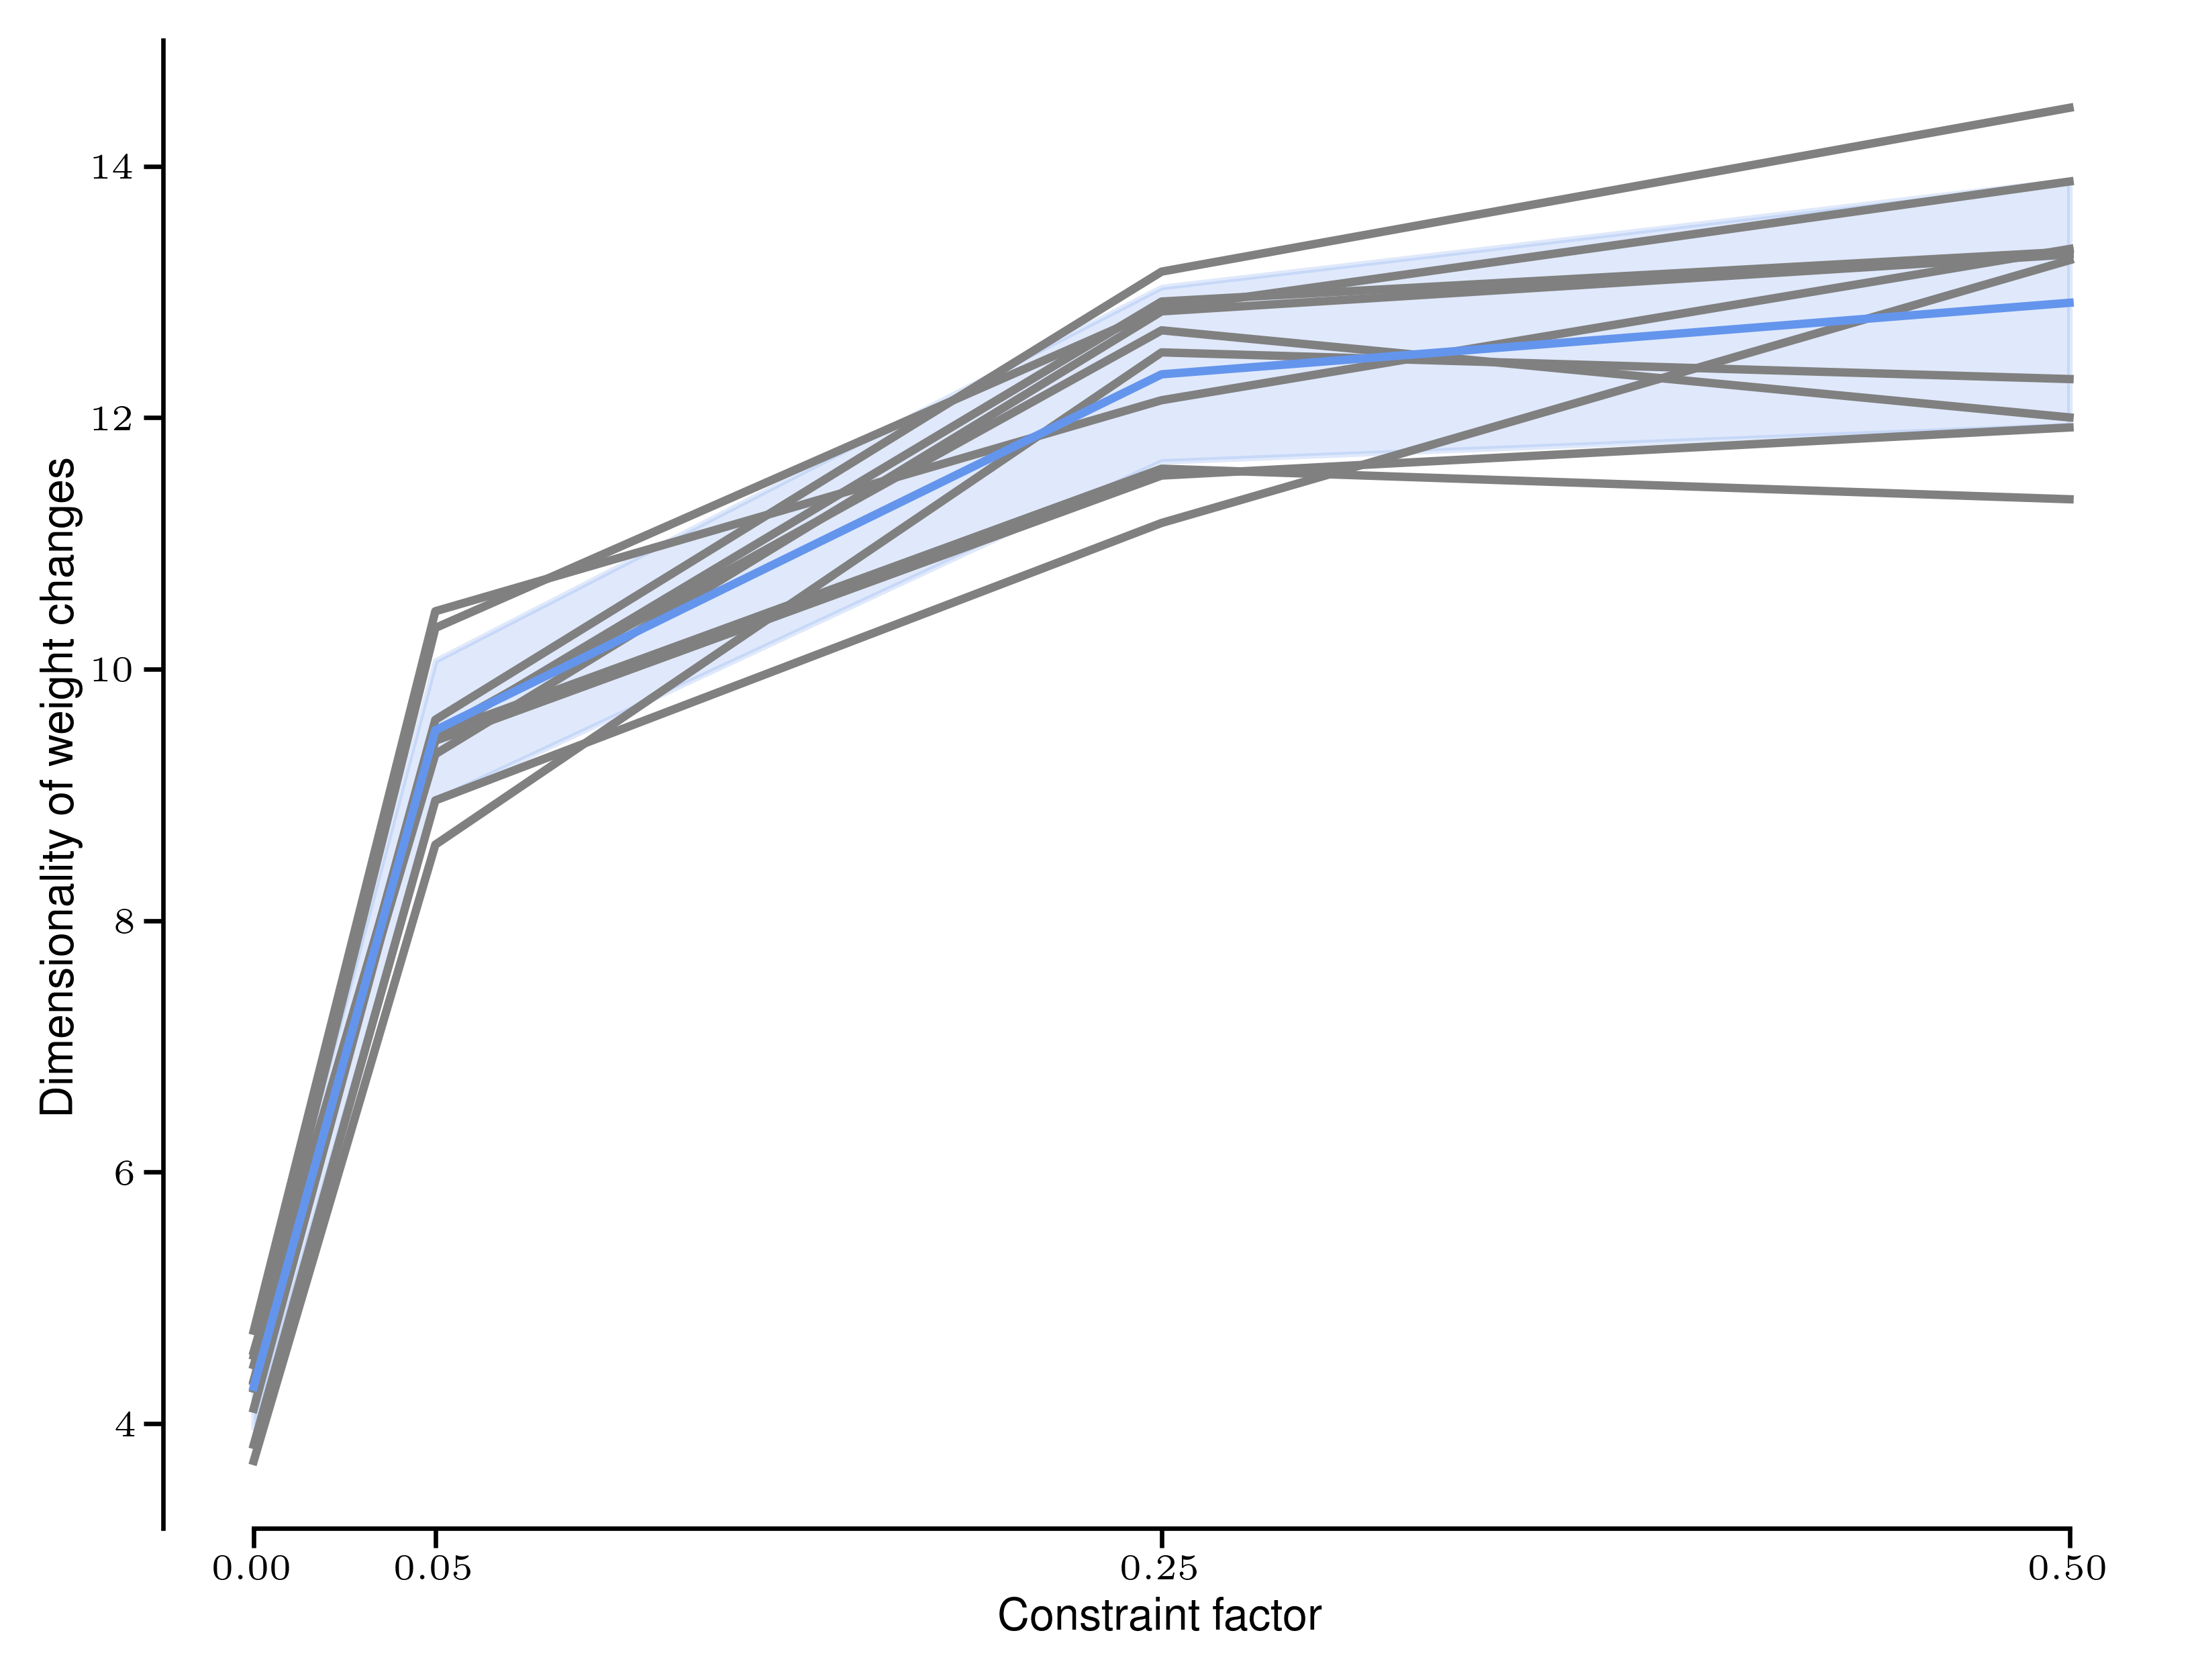

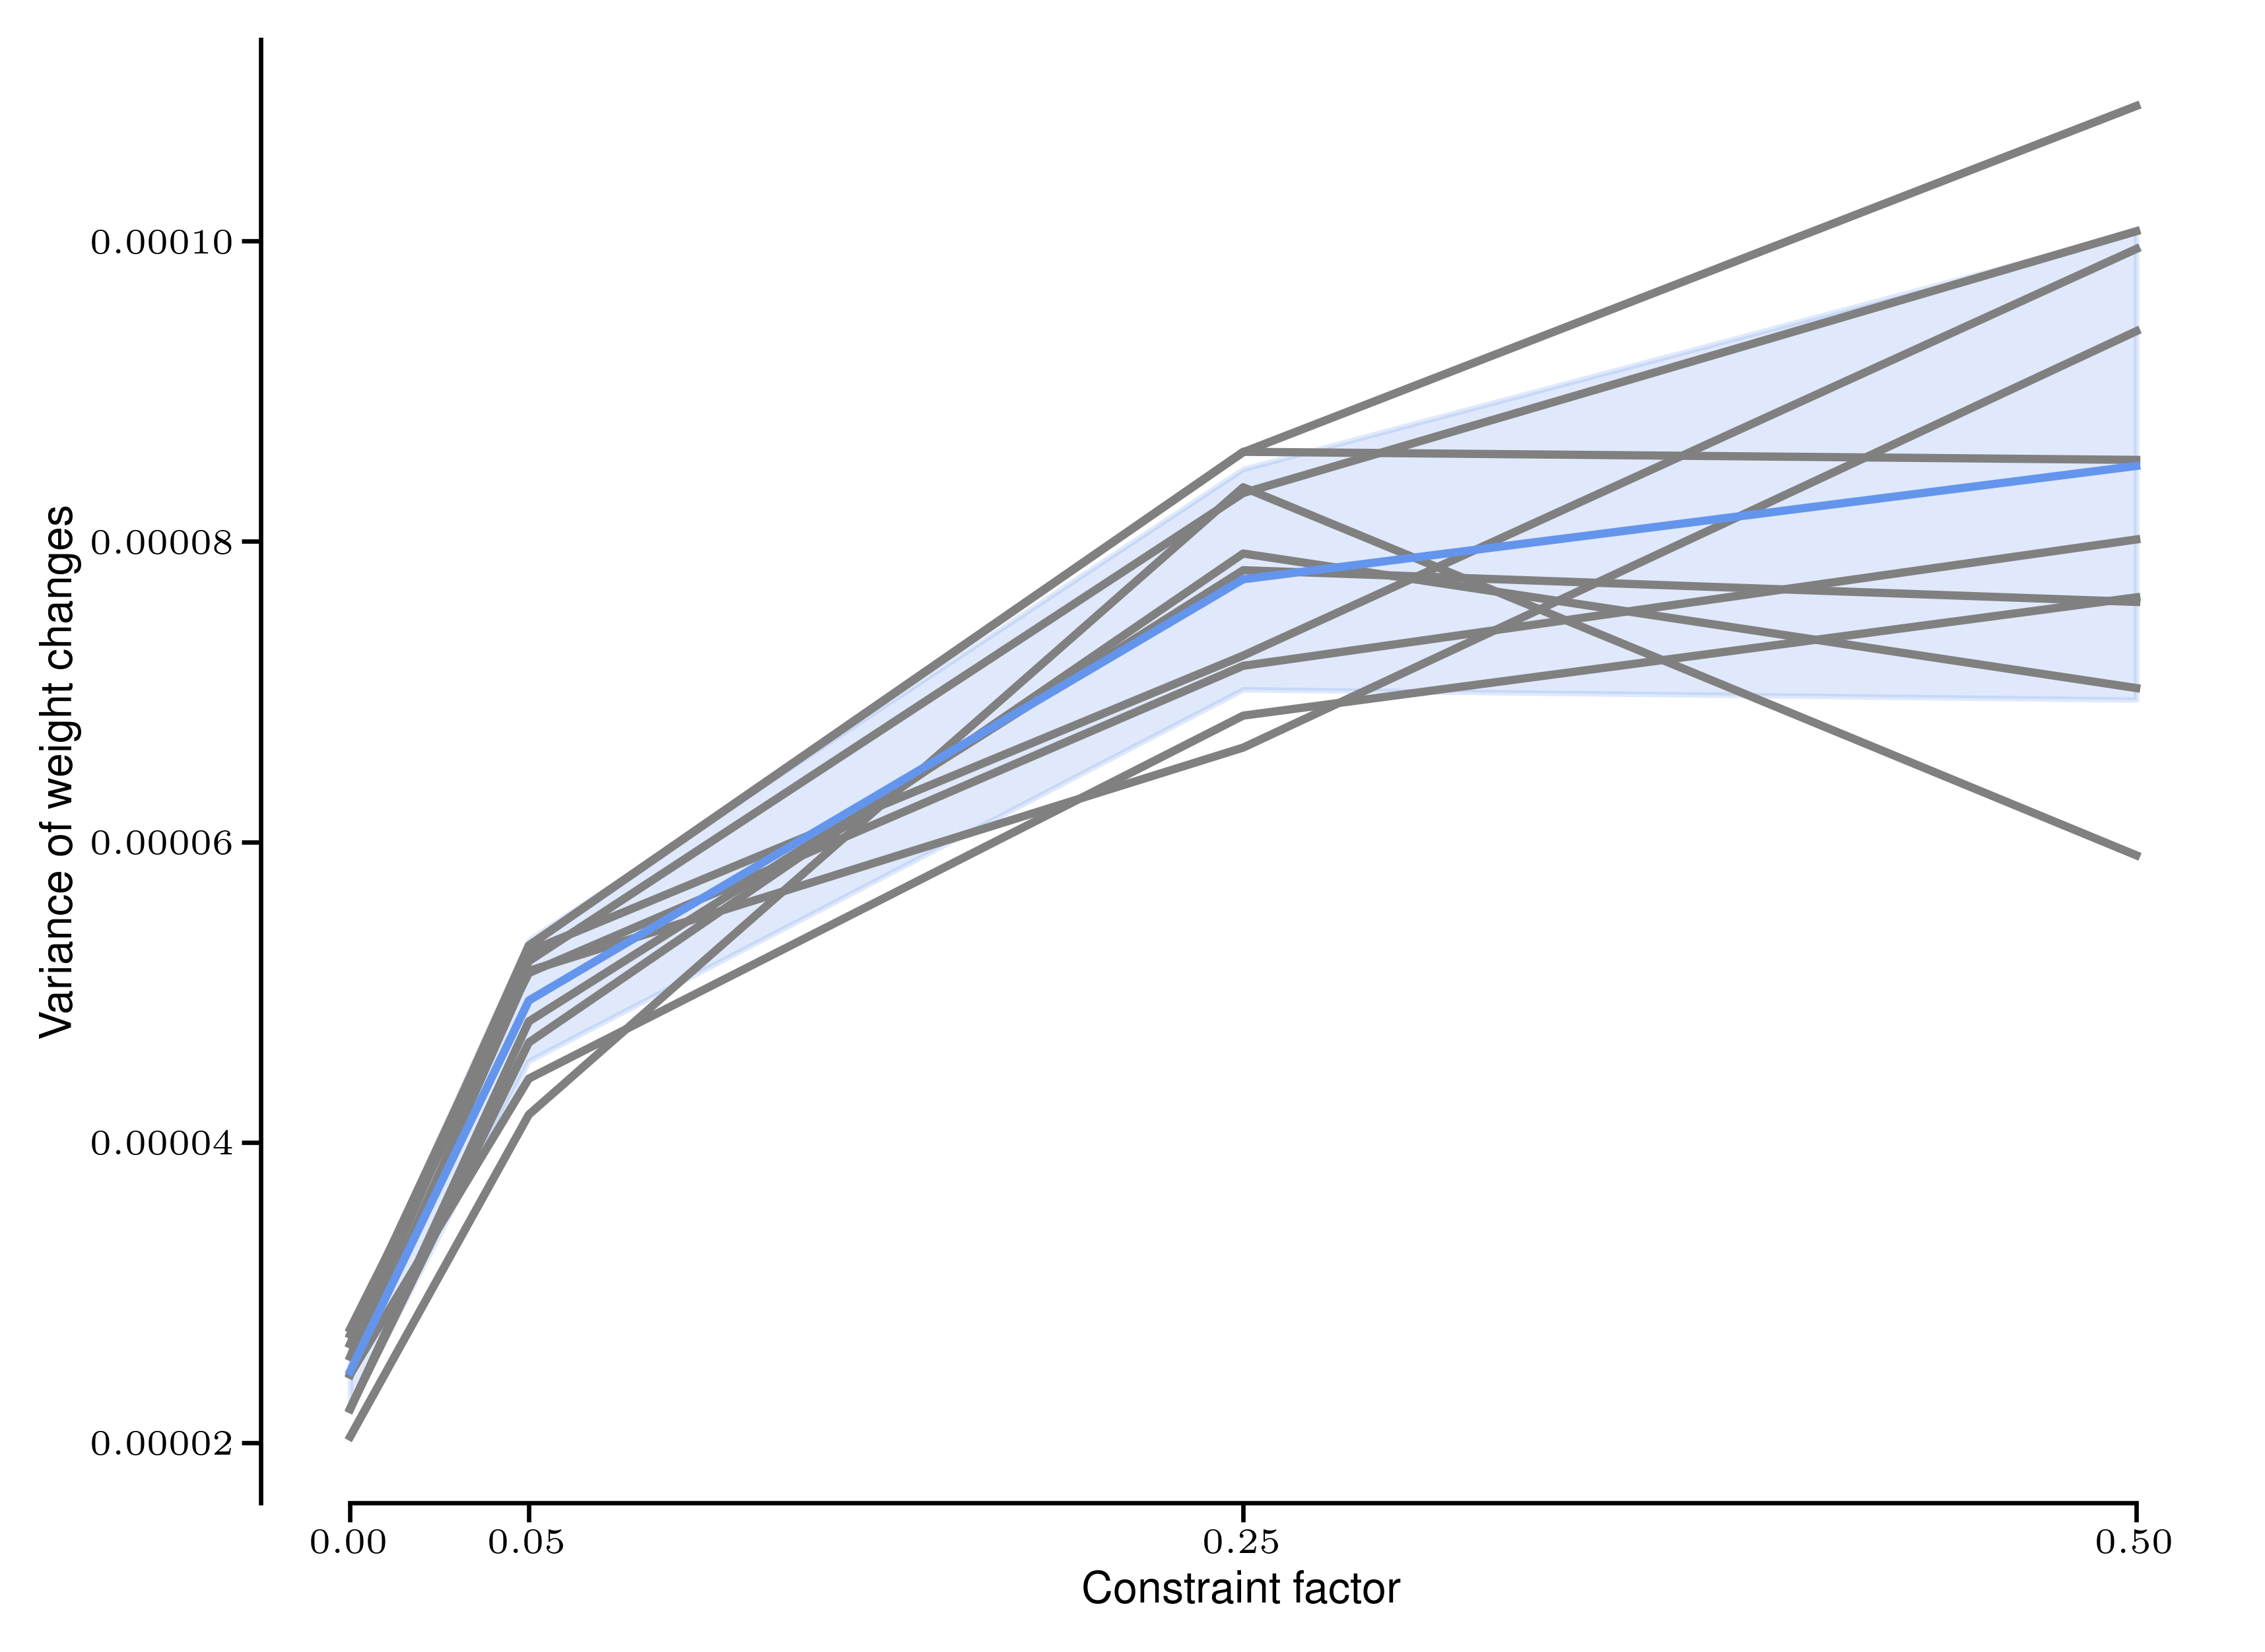

In [13]:
for measure, label in zip(['dimensionality', 'var'], ['Dimensionality', 'Variance']):
    fig, ax = plt.subplots()
    for seed in seeds2:
        data_ = data[data.seed == seed]
        sns.lineplot(data = data_, x = 'alpha', y = measure, color = 'grey')
    sns.lineplot(data = data, x = 'alpha', y = measure, errorbar='sd')

    ax.set_xlabel('Constraint factor')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # # ax.set_title(f'{defs.areas[2]} Alignment')
    # ax.legend(loc=(.55,.67))
    ax.set_ylabel(f'{label} of weight changes')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['bottom'].set_bounds([0,0.5])
    plt.xticks(alphas)
    info = '_'.join([measure])
    plt.savefig(FIGPATH / ("RNN-dw-"+info+'.pdf'), format= 'pdf')
